In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Monto Carlo for Mean Exit Time
1. Choose step size $\Delta t$
2. Choose a number of paths, M

```Python
for s = 1 to M: 
        set t_n=0 and X_n=X_0
        While X_n > a and X_n < b:
            eps_n = N(0,1)
            X_n = X_n + delta_t f(X_n) + sqrt(delta_t) * eps_n * g(X_n)
            t_n = t_n + delta_t
        T_exit = t_n - 0.5*delta_t
a_M = (1/M)* sum(T_exit)
b2_M = (1/M-1)*sum(T_exit - a_M)**2```

## Sources of error 
1. Sampling error arising from approximation of an expected value by sample mean 
2. Discritisation error
3. Risk of missing exit point within an interval $t_{i} < t < t_{i+1}$

Solutions:
1. Adaptive timesteps
2. After each step, calculate the probability that an exit was missed. Then draw from a uniform (0, 1) random number generator in order to decide whether to record an exit.
3. Use random stepsizes from a suitable exponential distribution.

In [2]:
class AdaptiveTimestep:
    """
    The class that contains methods for adaptive timesteps
    """
    def __init__(self):
        pass
    
    # TODO: Need tp update number of iterations accordingly
    # TODO: Stop process when hit the boundaries
    # Tanh is not appropriate for process which changes are very small and initial value is close to the boundareis
    # TODO: choice of distance function must be based on the stochastic process (how fast they change along y-axis in 1D)
    # The adaption can be calibrated by sampling from process to examine rate of change (learn the apdation)
    # Use Interative method to find the exact hitting time after crossing a boundary rather than taking average
    # TODO: Store value of timesteps and add visualisation of how timesteps chenage according to the value of function
    def naive_adaption(self, LB, UB, dt, curr_val):
        """
        A naive method to adapt timestep based on the distance to the boundaries
        """
        epsilon = 1e-10
        dist = min(abs(curr_val - LB), abs(curr_val - UB))
        dt_new = (abs(np.tanh(dist))+epsilon) * dt
        return dt_new

## Mean exit time for deterministic ODE ($dX_{t} = f(X_{t})dt + g(X(t))dW(t), X(0) = X_{0}$)
$u(x)$ denotes $T_{exit}^{mean}$
$$\frac{1}{2}g^2(x)\frac{d^{2}u}{dx^{2}} + f(x)\frac{du}{dx}=-1$$
$$u(a) = u(b) = b$$

## Example (Asset Prices) ($f(x) = \mu X, g(x) = \sigma X$)
$$X_{t} = \mu X dt + \sigma X dW \qquad 0 < a < X_{0} < b$$
We are interested in expected value of the first time that the asset either dips below the lower bound a or rises above the upper bound b.
The analystical solution for mean exit time can e computed by  solving the following ODE:
$$\frac{1}{2}\sigma^{2}x^{2}\frac{d^{2}x}{dx^{2}} + \mu x \frac{du}{dx} = -1 \qquad a < x< b and u(a) = u(b) = 0$$
$$u(x) = \frac{1}{\frac{1}{2}\sigma^{2}-\mu} \left( log(\frac{x}{a})- \frac{1 - (x/a)^{1-2 \mu/\sigma^{2}}}{1 - (b/a)^{1-2\mu / \sigma^{2}}}log(b/a)\right) $$

In [3]:
class AssetPrice:
    """
    This is a class for Asset Price ODE. 
    It contains methods for finding exact solution, plotting and exat mean hitting time.
    Arguments:
    a: Lower bound
    b: Upper bound
    mu: mu
    sigma: sigma
    """
    def __init__(self, a, b, mu, sigma):
        self.a = a
        self.b = b
        self.mu = mu
        self.sigma = sigma
        self.Xt = None
  
    def Xt_exact(self,X0,duration,dt, adaptive= False):
        """
        Methods that return paths of X(t)
        
        Arguments:
        X0: Initial value
        duration: The duration for running process
        dt: timestep
        
        Return: Array of a path
        """
        t = np.arange(0,duration,dt)
        n = int(duration/dt)
        X = np.zeros(n)
        X[0] = X0
        
        if adaptive:
            AdaptiveT =  AdaptiveTimestep()
            for i in range(1,n):
                dW = np.sqrt(dt)*np.random.randn() # increments
                dt_new = AdaptiveT.naive_adaption(LB=self.a, UB=self.b, dt = dt, curr_val=X[i-1])
                X[i] = X[i-1]*np.exp((self.mu - 0.5*self.sigma**2)*dt_new + self.sigma*dW);
            
        else:
            for i in range(1,n):
                dW = np.sqrt(dt)*np.random.randn() # increments
                X[i] = X[i-1]*np.exp((self.mu - 0.5*self.sigma**2)*dt + self.sigma*dW);
                
        return X
    
    def _plot(self,X0,duration,dt):
        """
        Method to plot a path
        
        Arguments:
        X0: intial value
        duration: The duration for running process
        dt: timestep
        """
        t = np.arange(0,duration,dt)
        xt = self.Xt_exact(X0,duration,dt)
        plt.figure(figsize=(20,10))
        plt.plot(t, xt)
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.hlines(self.b, xmin=0, xmax=max(t), color='red', label='$b$')
        plt.hlines(self.a,xmin=0, xmax=max(t), color='blue', label='$a$')
        plt.title('Stock Price SDE')
        plt.legend()
    
    def Ux(self,x):
        """
        Method to return exact mean hitting time
        
        Arguments:
        x: Path values (array)
        
        Return: Array containing exact mean hitting time for given initial values
        
        """
        c1 = 1/(0.5*self.sigma**2 - self.mu)
        c2 = 1 - (x/self.a)**(1-2*self.mu/self.sigma**2)
        c3 = 1 - (self.b/self.a)**(1-2*self.mu/self.sigma**2)
        ux = (1/c1)*(np.log(x/self.a) - (c2/c3)*np.log(self.b/self.a))
        return ux

In [4]:
AssetPrice1 = AssetPrice(a=0.5, b=2, mu=0.1, sigma=0.2)

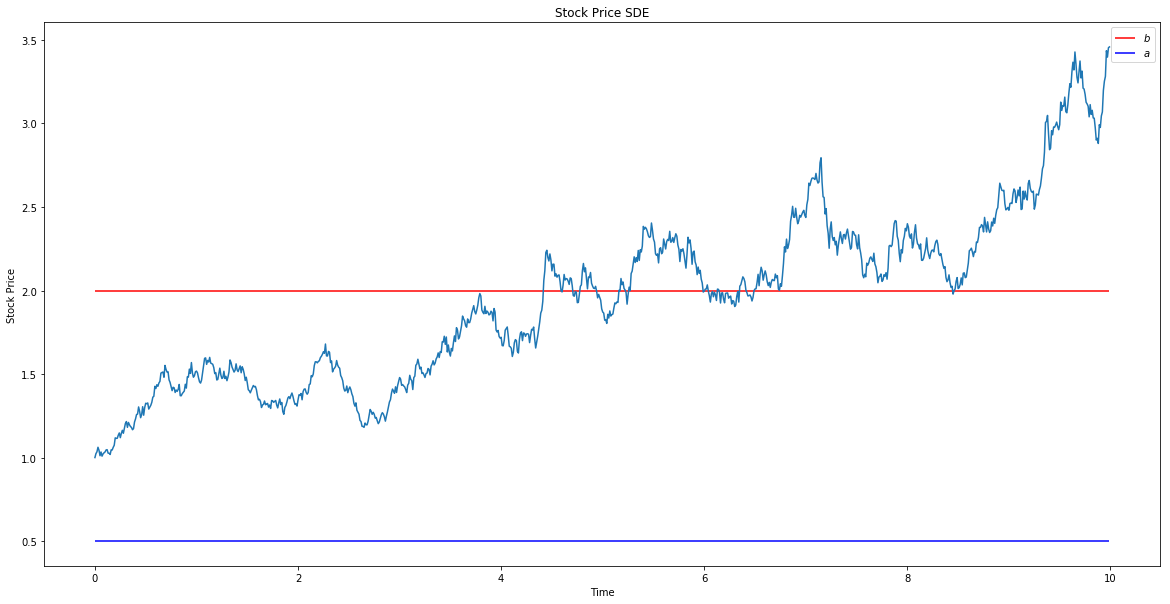

In [8]:
AssetPrice1._plot(X0 = 1,duration = 10, dt = 0.01)

In [9]:
xVals = np.linspace(AssetPrice1.a, AssetPrice1.b, 1000)
uVals = AssetPrice1.Ux(xVals)

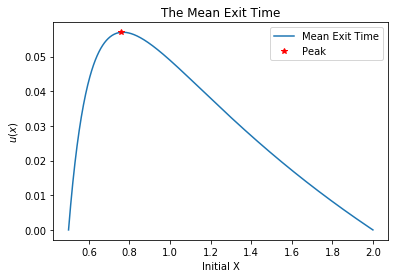

In [10]:
plt.plot(xVals, uVals, label='Mean Exit Time')
plt.plot(0.76, AssetPrice1.Ux(0.76),'*', color='red', label='Peak')
plt.xlabel('Initial X')
plt.ylabel('$u(x)$')
plt.title('The Mean Exit Time')
plt.legend()

In [11]:
class MontoCarlo:
    """
    This is a class that contain Monto Carlo methods
    Arguments:
    X0: Intial value
    M: Number of iteration
    dt: Timestep
    duration: The duration for running a process
    """
    def __init__(self, X0, M, dt, duration):
        self.X0 = X0
        self.M = M
        self.dt = dt 
        self.duration = duration
        self.n = int(duration / dt)
        self.Xn = np.zeros(self.n); self.Xn[0] = X0
        self.W = np.random.normal(0,1, self.n)
    

    def Euler_Maruyama(self, f, g):
        """
        Method that approxiamte a solution using Euler-Maruyama method
        
        Arguments:
        f: F(x)
        g: g(x)
        
        Return: Array containing path
        """
        for i in range(1, self.n-1):
            self.Xn[i] = self.Xn[i-1] + self.dt*f(Xn[i-1]) + g(x[i-1])*(self.W[i] - self.W[i-1])
        return self.Xn
    

    def Asset_Price_Exact(self, a, b, mu, sigma, adaptive=False):
        """
        Method to compute the hitting times for M interations for Asset Price
        
        Arguments
        a: Lower bound
        b: Upper bound
        mu: mu
        sigma: sigma
        
        Return: Numpy array of hitting time for each iteration
        """
        AP = AssetPrice(a=a, b=b, mu=mu, sigma=sigma)
        AP_samples = np.zeros(self.M)
        for t in tqdm(range(self.M)):
            AP_exact_sol = AP.Xt_exact(X0 = self.X0, duration = self.duration, dt = self.dt, adaptive=adaptive)
            hit_time = np.where((AP_exact_sol <= a) | (AP_exact_sol >= b))[0]
            hit_time = np.append(hit_time, int(1e10)) # Inf i.e never hit 
            AP_samples[t] = hit_time[0]*self.dt - 0.5*self.dt
        return AP_samples
        

In [12]:
MC1 = MontoCarlo(X0 = 1, M = int(5e4), dt=1e-2, duration=100)
AP1 = MC1.Asset_Price_Exact(a=0.5, b=2, mu=0.1, sigma=0.2)
AP2 = MC1.Asset_Price_Exact(a=0.5, b=2, mu=0.1, sigma=0.2, adaptive=True)

  0%|          | 79/50000 [00:05<57:27, 14.48it/s]  


KeyboardInterrupt: 

In [ ]:
exit_mean1 = np.mean(AP1)
exit_std1 = np.std(AP1)

cileft1 = exit_mean1 - 1.96*exit_std1/np.sqrt(MC1.M)
ciright1 = exit_mean1 + 1.96*exit_std1/np.sqrt(MC1.M)

print('Estimated Exit Time - Without Adaptive Timestep')
print('Estimated Exit Mean: {}'.format(exit_mean1))
print('Estimated Exit Mean std: {}'.format(exit_std1))
print('Estimated Exit Mean Confidence Interval: ({l},{r})'.format(l=cileft1,r=ciright1))

exit_mean2 = np.mean(AP2)
exit_std2 = np.std(AP2)

cileft2 = exit_mean2 - 1.96*exit_std2/np.sqrt(MC1.M)
ciright2 = exit_mean2 + 1.96*exit_std2/np.sqrt(MC1.M)

print('Estimated Exit Time - With Adaptive Timestep')
print('Estimated Exit Mean: {}'.format(exit_mean2))
print('Estimated Exit Mean std: {}'.format(exit_std2))
print('Estimated Exit Mean Confidence Interval: ({l},{r})'.format(l=cileft2,r=ciright2))

In [ ]:
plt.figure(figsize=(12,6))
(n, bins, patches) = plt.hist(AP1, bins=100, label='hst',)
plt.vlines(exit_mean1, ymin = 0, ymax =4000, label='Estimated Mean', color='red')
plt.vlines(7.6450, ymin = 0, ymax =4000, label='Exact Mean', color='blue')
plt.vlines(cileft1, ymin = 0, ymax =4000, label='0.025 Confidence Interval', color='purple')
plt.vlines(ciright1, ymin = 0, ymax =4000, label='0.975 Confidence Interval', color='purple')
plt.title('Histogram of mean exit times for $M = 5 × 10^5$ sample paths - Without Adaptive Timestep')
plt.xlabel('First Exit Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
(n, bins, patches) = plt.hist(AP2, bins=100, label='hst',)
plt.vlines(exit_mean2, ymin = 0, ymax =4000, label='Estimated Mean', color='red')
plt.vlines(7.6450, ymin = 0, ymax =4000, label='Exact Mean', color='blue')
plt.vlines(cileft2, ymin = 0, ymax =4000, label='0.025 Confidence Interval', color='purple')
plt.vlines(ciright2, ymin = 0, ymax =4000, label='0.975 Confidence Interval', color='purple')
plt.title('Histogram of mean exit times for $M = 5 × 10^5$ sample paths - With Adaptive Timestep')
plt.xlabel('First Exit Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()